# 8장 Image captioning


In [1]:
import urllib.request # URL을 통해 데이터를 다운로드하는 모듈
import zipfile # ZIP 파일을 다루는 모듈
import os # 운영체제와 상호작용하여 파일 시스템을 제어하는 모듈

# 1. COCO 데이터셋 다운로드
## 주의!!! 용량 매우 큼 원드라이브에서 말고 로컬폴더에서만 다운로드할 것

In [2]:
import os
import urllib.request
import zipfile

# 기준 폴더 설정
BASE_DIR = r'C:\python\ch08\data_dir'

def download_and_extract(url, filename, extract_path, expected_folder):
    """URL에서 파일을 다운로드하고 압축해제. 이미 존재하면 스킵"""
    
    # 절대 경로로 변환
    full_extract_path = os.path.join(BASE_DIR, extract_path)
    expected_folder_path = os.path.join(full_extract_path, expected_folder)
    
    # 이미 압축해제된 폴더가 존재하는지 확인
    if os.path.exists(full_extract_path) and os.path.exists(expected_folder_path):
        print(f"{expected_folder} 폴더가 이미 존재합니다. 스킵합니다.")
        return
    
    # zip 파일이 이미 다운로드되어 있는지 확인
    if not os.path.exists(filename):
        print(f"{filename} 다운로드를 시작합니다...")
        zip_path, _ = urllib.request.urlretrieve(url, filename=filename)
        print(f"{filename} 다운로드 완료")
    else:
        print(f"{filename}이 이미 존재합니다. 다운로드를 스킵합니다.")
    
    # 압축해제할 폴더가 없으면 생성
    if not os.path.exists(full_extract_path):
        os.makedirs(full_extract_path)
        print(f"{full_extract_path} 폴더를 생성했습니다.")
    
    # 압축해제
    print(f"{filename} 압축해제를 시작합니다...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(full_extract_path)
    print(f"{filename} 압축해제 완료")

# Annotations 다운로드 및 압축해제
print("=== COCO Annotations 다운로드 ===")
download_and_extract(
    url="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
    filename="annotations_trainval2014.zip",
    extract_path="annotations_trainval2014",
    expected_folder="annotations"
)

# Train2014 이미지 다운로드 및 압축해제
print("\n=== COCO Train2014 Images 다운로드 ===")
download_and_extract(
    url="http://images.cocodataset.org/zips/train2014.zip",
    filename="train2014.zip",
    extract_path="train2014",
    expected_folder="train2014"
)

# Val2014 이미지 다운로드 및 압축해제
print("\n=== COCO Val2014 Images 다운로드 ===")
download_and_extract(
    url="http://images.cocodataset.org/zips/val2014.zip",
    filename="val2014.zip",
    extract_path="val2014",
    expected_folder="val2014"
)

print("\n모든 COCO 데이터셋 다운로드 및 압축해제가 완료되었습니다.")


=== COCO Annotations 다운로드 ===
annotations 폴더가 이미 존재합니다. 스킵합니다.

=== COCO Train2014 Images 다운로드 ===
train2014 폴더가 이미 존재합니다. 스킵합니다.

=== COCO Val2014 Images 다운로드 ===
val2014 폴더가 이미 존재합니다. 스킵합니다.

모든 COCO 데이터셋 다운로드 및 압축해제가 완료되었습니다.


2. 라이브러리, 토크나이저 임포트

In [3]:
## import dependencies

import os # 운영체제 기능 (파일 경로 등)
import nltk # 자연어 처리 툴킷 (토큰화)
import pickle # 파이썬 객체를 파일로 저장/불러오기 (단어장 저장)
import numpy as np # 수치 연산 라이브러리 (배열 계산)
from PIL import Image # 이미지 처리 라이브러리 (이미지 열기, 크기 조절)
from collections import Counter # 컨테이너 데이터 타입 (단어 빈도수 계산)
from pycocotools.coco import COCO # COCO 데이터셋 API (캡션 데이터 로딩)
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리 (이미지 출력)
 
import torch # 파이토치(PyTorch) 딥러닝 프레임워크
from torch import nn, optim # nn: 신경망 모듈, optim: 최적화 알고리즘
from torch.utils.data import Dataset, DataLoader # 데이터셋 및 데이터 로더 클래스
from torchvision import transforms, models # transforms: 이미지 변환, models: 사전 훈련된 모델
from torch.nn.utils.rnn import pack_padded_sequence # 가변 길이 시퀀스 처리를 위한 함수

# Tokenizer download
# nltk 라이브러리에서 문장을 단어 단위로 분리(토큰화)하는 데 필요한 'punkt' 데이터를 다운로드합니다.
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ju0ko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ju0ko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

2.1 COCO 데이터 구조 확인 (디버깅용)

In [4]:
import json # JSON 파일 형식을 다루기 위한 라이브러리
# 훈련 캡션이 포함된 JSON 파일의 경로 지정
# json_file = 'data_dir/annotations_trainval2014/annotations/captions_train2014.json'
json_file = r'C:\python\ch08\data_dir\annotations_trainval2014\annotations\captions_train2014.json'

# 'with open' 구문을 사용하여 파일을 열고, 작업이 끝나면 자동으로 닫음
# 'r'은 읽기 모드를 의미
with open(json_file, 'r') as f:
    # json.load(f): 파일 객체 f로부터 JSON 데이터를 읽어와 파이썬 딕셔너리 형태로 변환
    data = json.load(f)

# 로드된 데이터의 최상위 키(key)들을 출력하여 데이터 구조 확인
# 예: dict_keys(['info', 'images', 'licenses', 'annotations'])
print(data.keys())
# 'images' 리스트의 첫 번째 요소(이미지 정보)를 출력
display(data['images'][0])
# 'annotations' 리스트의 첫 번째 요소(캡션 정보)를 출력
display(data['annotations'][0])


# COCO API를 사용하여 JSON 파일을 로드. 이 API는 이미지 ID로 캡션을 쉽게 찾게 해줌
coco = COCO(json_file)

# coco.anns는 주석(annotation) ID를 키로, 캡션 및 관련 이미지 ID를 값으로 갖는 딕셔너리
# 예: {48: {'image_id': 318556, 'id': 48, 'caption': 'A very clean...'}, ...}
# display(coco.anns)

# coco.loadImgs(image_id)는 주어진 이미지 ID에 해당하는 이미지 정보를 리스트 형태로 반환
# 예: [{'license': 3, 'file_name': 'COCO_train2014_000000318556.jpg', ...}]
print(coco.loadImgs(318556))


# coco.anns 딕셔너리의 모든 키(주석 ID)를 리스트로 변환
coco_keys = list(coco.anns.keys())
# 처음 10개의 주석 ID를 출력
print(coco_keys[:10])
# 전체 주석의 개수를 출력
print(len(coco_keys))

dict_keys(['info', 'images', 'licenses', 'annotations'])


{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
[{'license': 1, 'file_name': 'COCO_train2014_000000318556.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000318556.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-15 05:00:35', 'flickr_url': 'http://farm4.staticflickr.com/3133/3378902101_3c9fa16b84_z.jpg', 'id': 318556}]
[48, 67, 126, 148, 173, 188, 219, 255, 272, 288]
414113


In [5]:
# coco.anns는 주석(annotation) ID를 키로, 캡션 및 관련 이미지 ID를 값으로 갖는 딕셔너리
# 예: {48: {'image_id': 318556, 'id': 48, 'caption': 'A very clean...'}, ...}
display(coco.anns)

{48: {'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 67: {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 126: {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 148: {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 173: {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '},
 188: {'image_id': 379340,
  'id': 188,
  'caption': 'A vandalized stop sign and a red beetle on the road'},
 219: {'image_id': 318556,
  'id': 219,
  'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'},
 255: {'image_id': 318556,
  'id': 255,
  'caption': 'An angled view of a beautifully decorated bathroom.'},
 272: {'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'

3. 단어사전(Vocabulary) 구축

In [6]:
# 단어장을 표현하기 위한 클래스
class Vocab(object):
    """단어와 인덱스를 매핑하는 간단한 단어사전 래퍼."""
    def __init__(self):
        # w2i: 단어(word)를 정수 인덱스(integer)로 매핑하는 딕셔너리
        self.w2i = {}  # 단어 -> 인덱스 딕셔너리
        # i2w: 정수 인덱스(integer)를 단어(word)로 매핑하는 딕셔너리
        self.i2w = {}  # 인덱스 -> 단어 딕셔너리
        # 새로운 단어에 할당될 고유한 인덱스
        self.index = 0

    # 객체를 함수처럼 호출할 수 있게 해주는 특별 메소드. e.g., vocab('hello')
    def __call__(self, token):
        # 만약 토큰이 단어장에 없으면, '<unk>' (알 수 없는 단어) 토큰의 인덱스를 반환
        if token not in self.w2i:
            return self.w2i['<unk>']
        # 토큰이 단어장에 있으면 해당 인덱스를 반환
        return self.w2i[token]

    # 단어장의 크기(총 단어 수)를 반환하는 특별 메소드. e.g., len(vocab)
    def __len__(self):
        return len(self.w2i)
    
    # 단어장에 새로운 토큰을 추가하는 메소드
    def add_token(self, token):
        # 토큰이 단어장에 아직 없는 경우에만 추가
        if token not in self.w2i:
            # w2i와 i2w 딕셔너리에 새로운 토큰과 현재 인덱스를 추가
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            # 다음 단어를 위해 인덱스를 1 증가
            self.index += 1

# JSON 파일로부터 단어장을 구축하는 함수
def build_vocabulary(json, threshold):
    """간단한 단어사전 래퍼를 구축."""
    # COCO API를 사용하여 캡션 데이터를 로드
    coco = COCO(json)
    # 단어의 빈도를 계산하기 위해 Counter 객체 생성
    counter = Counter()
    # 모든 캡션의 ID를 가져옴
    # {48: {'image_id': 318556, 'id': 48, 'caption': 'A very clean...'}, ...}
    ids = coco.anns.keys()
    # 모든 캡션에 대해 반복 작업을 수행
    for i, id in enumerate(ids):
        # 현재 ID에 해당하는 캡션 문자열을 가져옴
        caption = str(coco.anns[id]['caption'])
        # 캡션을 소문자로 변환하고 nltk를 사용하여 단어 단위로 토큰화
        # 예: "A dog is running." -> ['a', 'dog', 'is', 'running', '.']
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        # counter.update()로 토큰 리스트에 있는 각 단어의 빈도를 업데이트
        counter.update(tokens)

        # 1000개의 캡션을 처리할 때마다 진행 상황 출력
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # 단어의 빈도가 'threshold' 값보다 낮은 단어는 무시하고, 높은 단어들만 리스트로 만듦
    # 이는 너무 드물게 나타나는 단어를 제거하여 단어장의 크기를 줄이고 모델의 일반화 성능을 높이는 데 도움을 줌
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # Vocab 클래스의 인스턴스를 생성
    vocab = Vocab()
    # 문장의 길이를 맞추기 위한 패딩(padding) 토큰, 문장의 시작과 끝을 나타내는 토큰,
    # 단어장에 없는 단어를 나타내는 알 수 없는(unknown) 토큰 등 특수 토큰들을 추가
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')

    # 빈도수 기준을 통과한 단어들을 단어장에 추가
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab
 
# 생성된 단어장 객체를 나중에 재사용할 수 있도록 파일로 저장
vocab_path = r'C:\python\ch08\data_dir\vocabulary.pkl'

# 이미 단어장 파일이 존재하는지 확인
if os.path.exists(vocab_path):
    print(f"단어장 파일이 이미 존재합니다. 기존 파일을 사용합니다: {vocab_path}")
    # 기존 단어장 파일을 로드
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    print(f"단어장 로드 완료. 총 {len(vocab)}개의 단어가 포함되어 있습니다.")
else:
    print("단어장 파일이 없습니다. 새로 생성합니다...")
    # build_vocabulary 함수를 호출하여 단어장을 생성
    # - json: 캡션 데이터 파일 경로.
    # - threshold: 단어장에 포함되기 위한 최소 빈도수. 4번 미만으로 등장하는 단어는 제외.
    # vocab = build_vocabulary(json=r'./data_dir/annotations_trainval2014/annotations/captions_train2014.json', threshold=4)
    vocab = build_vocabulary(json=r'C:\python\ch08\data_dir\annotations_trainval2014\annotations\captions_train2014.json', threshold=4)

    # 'wb'는 쓰기(write) 및 바이너리(binary) 모드를 의미. pickle은 바이너리 파일로 저장해야 함
    with open(vocab_path, 'wb') as f:
        # pickle.dump(object, file): 지정된 객체(vocab)를 파일(f)에 저장(직렬화)
        pickle.dump(vocab, f)

단어장 파일이 이미 존재합니다. 기존 파일을 사용합니다: C:\python\ch08\data_dir\vocabulary.pkl


단어장 로드 완료. 총 9948개의 단어가 포함되어 있습니다.


In [7]:
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

# %%
## Check vocab dictionary
# 단어 -> 인덱스 딕셔너리(w2i) 내용 확인
display(vocab.w2i)
# 인덱스 -> 단어 딕셔너리(i2w) 내용 확인
# display(vocab.i2w)


Total vocabulary size: 9948
Saved the vocabulary wrapper to 'C:\python\ch08\data_dir\vocabulary.pkl'


{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '<unk>': 3,
 'a': 4,
 'very': 5,
 'clean': 6,
 'and': 7,
 'well': 8,
 'decorated': 9,
 'empty': 10,
 'bathroom': 11,
 'panoramic': 12,
 'view': 13,
 'of': 14,
 'kitchen': 15,
 'all': 16,
 'its': 17,
 'appliances': 18,
 '.': 19,
 'blue': 20,
 'white': 21,
 'with': 22,
 'butterfly': 23,
 'themed': 24,
 'wall': 25,
 'tiles': 26,
 'photo': 27,
 'dining': 28,
 'room': 29,
 'stop': 30,
 'sign': 31,
 'across': 32,
 'the': 33,
 'street': 34,
 'from': 35,
 'red': 36,
 'car': 37,
 'vandalized': 38,
 'beetle': 39,
 'on': 40,
 'road': 41,
 'border': 42,
 'butterflies': 43,
 'paint': 44,
 'walls': 45,
 'above': 46,
 'it': 47,
 'an': 48,
 'angled': 49,
 'beautifully': 50,
 'two': 51,
 'people': 52,
 'are': 53,
 'walking': 54,
 'down': 55,
 'beach': 56,
 'sink': 57,
 'toilet': 58,
 'inside': 59,
 'small': 60,
 'black': 61,
 'square': 62,
 'tile': 63,
 'floor': 64,
 'that': 65,
 'needs': 66,
 'repairs': 67,
 'vanity': 68,
 'contains': 69,
 'sinks': 70,
 'towel

4. 이미지 리사이즈

In [8]:
# PIL Image 객체의 크기를 조절하는 함수
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    # image.resize(shape, resample_method): 이미지 크기를 변경
    # - shape: 목표 크기 [너비, 높이]. 예: [256, 256]
    # - Image.Resampling.BILINEAR: 크기 조절 시 픽셀 값을 계산하는 보간(interpolation) 방법 중 하나
    return image.resize(shape, Image.Resampling.BILINEAR)
 
# 특정 폴더에 있는 모든 이미지의 크기를 조절하여 다른 폴더에 저장하는 함수
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    # 출력 폴더가 이미 존재하고 처리된 파일이 있는지 확인
    if os.path.exists(output_path):
        # 기존 처리된 파일 수 확인
        existing_files = os.listdir(output_path)
        original_files = os.listdir(image_path)
        
        # 이미 모든 파일이 처리되었다면 스킵
        if len(existing_files) == len(original_files):
            print(f"이미지 처리가 이미 완료되었습니다. 스킵합니다. ({len(existing_files)}개 파일)")
            return
    # 결과물을 저장할 폴더가 존재하지 않으면 새로 생성
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    # image_path에 있는 모든 파일(이미지)의 목록을 가져옴
    images = os.listdir(image_path)
    num_im = len(images)
    # 각 이미지에 대해 반복 작업을 수행
    for i, im in enumerate(images):
        # os.path.join으로 운영체제에 맞는 파일 경로를 생성하고, 'r+b' 모드(읽기+바이너리)로 엶
        with open(os.path.join(image_path, im), 'r+b') as f:
            # 파일 객체 f로부터 이미지를 엶
            with Image.open(f) as image:
                # 위에서 정의한 reshape_image 함수를 사용하여 이미지 크기를 조절
                image = reshape_image(image, shape)
                # 크기가 조절된 이미지를 output_path에 저장. image.format은 원본 파일 형식(예: 'JPEG')을 유지
                image.save(os.path.join(output_path, im), image.format)
        # 100개의 이미지를 처리할 때마다 진행 상황 출력
        if (i+1) % 10000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

# 원본 훈련 이미지가 있는 경로
# image_path = './data_dir/train2014/train2014'
image_path = r'C:\python\ch08\data_dir/train2014/train2014'
# 크기를 조절한 이미지를 저장할 경로
# output_path = './data_dir/resized_images/'
output_path = r'C:\python\ch08\data_dir/resized_images/'
# 함수를 호출하여 이미지 크기 조절을 실행
# 모든 이미지를 256x256 픽셀 크기로 통일
image_shape = [256, 256]
# 함수를 호출하여 이미지 크기 조절을 실행
reshape_images(image_path, output_path, image_shape)

이미지 처리가 이미 완료되었습니다. 스킵합니다. (82783개 파일)


5. 데이터 로더(Data Loader) 구현

In [9]:
# imgs, caps = zip_data # ## data_batch
# def __getitem__(self, idx):
#     image = load_image(idx)           # Tensor
#     caption = get_caption(idx)        # String
#     return image, caption


# # Then if your batch_size=4, data_batch will be:
# [
#   (image1, caption1),
#   (image2, caption2),
#   (image3, caption3),
#   (image4, caption4)
# ]


data = [
  ("image1", "caption1"),
  ("image2", "caption2"),
  ("image3", "caption3"),
  ("image4", "caption4")
]

imgs, caps = zip(*data)
print(imgs)
print(caps)

# imgs = torch.stacks(imgs, 0)
# cap_lens = [len(cap) for cap in caps]

('image1', 'image2', 'image3', 'image4')
('caption1', 'caption2', 'caption3', 'caption4')


In [10]:
imgs_list = [torch.rand((2, 3)),
             torch.rand((2, 3))]
display(imgs_list)
print("=" * 100)
torch.stack(imgs_list, 0).shape


[tensor([[0.9448, 0.1841, 0.0618],
         [0.4056, 0.3385, 0.5462]]),
 tensor([[0.7132, 0.0961, 0.8882],
         [0.9314, 0.4603, 0.0029]])]

torch.Size([2, 2, 3])

In [11]:
tgts = torch.zeros(10, 10)
tgts    # 이렇게 최대 크기의 문장 길이만큼 제로패딩을 미리 만들고, 문장을 0자리에 집어넣는 방식로 구현예정

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
# torch.utils.data.Dataset을 상속받아 우리만의 커스텀 데이터셋 클래스 정의
class CustomCocoDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, imgs_path, coco_json_path, vocabulary, transform=None):
        """
        Args:
            imgs_path: 이미지가 저장된 디렉토리 경로.
            coco_json_path: COCO 주석(캡션) json 파일 경로.
            vocabulary: 미리 빌드해둔 단어장(Vocab) 객체.
            transform: 이미지에 적용할 전처리 및 증강(augmentation) transform.
        """
        self.root = imgs_path
        self.coco_data = COCO(coco_json_path)
        # self.coco_data.anns.keys()는 모든 캡션의 고유 ID 리스트.
        # 이 ID를 사용하여 데이터셋의 각 항목에 접근.
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform

    # 데이터셋의 총 샘플 수를 반환하는 메소드
    def __len__(self):
        return len(self.indices)

    # 데이터셋의 특정 인덱스(idx)에 해당하는 데이터(이미지와 캡션)를 반환하는 메소 드
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        
        # 주어진 인덱스(idx)에 해당하는 캡션 ID를 가져옴
        annotation_id = self.indices[idx]
        
        # 캡션 ID를 사용하여 캡션 텍스트와 이미지 ID를 가져옴
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        
        # 이미지 ID를 사용하여 이미지 파일 이름을 가져옴
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        # 이미지 파일을 열고, 채널 수가 다른 이미지를 위해 'RGB' 형식으로 변환
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        # __init__에서 transform이 지정되었다면, 이미지에 해당 변환을 적용
        # (예: 크기 조절, 텐서로 변환, 정규화 등)
        if self.transform is not None:
            image = self.transform(image)

        # 캡션(문자열)을 단어 인덱스(정수)의 리스트로 변환
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        # 문장의 시작을 알리는 '<start>' 토큰의 인덱스를 추가
        caption.append(vocabulary('<start>'))
        # 각 단어 토큰을 해당하는 인덱스로 변환하여 리스트에 추가
        caption.extend([vocabulary(token) for token in word_tokens])
        # 문장의 끝을 알리는 '<end>' 토큰의 인덱스를 추가
        caption.append(vocabulary('<end>'))
        # 최종적으로 인덱스 리스트를 파이토치 텐서로 변환
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
    
# DataLoader가 데이터셋에서 샘플들을 가져와 하나의 미니배치로 묶는 방법을 정의하는 함수.
# 캡션의 길이가 서로 다르기 때문에, 이를 동일한 길이로 맞춰주는 '패딩' 작업이 필요하여 커스텀 함수를 사용.
def collate_function(data_batch):
    """
    Args:
        data_batch: __getitem__에서 반환된 (이미지, 캡션) 튜플들의 리스트.
                    예: [(img1, cap1), (img2, cap2), ...]
    Returns:
        images: (batch_size, 3, 224, 224) 크기의 이미지 텐서.
        targets: (batch_size, padded_length) 크기의 패딩된 캡션 텐서.
        lengths: 각 캡션의 원래 길이를 담은 리스트.
    """
    # 캡션 길이를 기준으로 데이터 배치를 내림차순으로 정렬.
    # 이는 나중에 pack_padded_sequence 함수를 사용하기 위해 필수적.
    # sort 함수에서 key 인자는 값을 받는 것이 아니라, 각 리스트 원소를 인자로 받아 
    #     "정렬 기준이 될 값"을 반환하는 함수(콜러블)를 받습니다.
    # 즉, key 인자에 함수(예: lambda 식)를 넘기면, 
    #     내부에서 리스트의 각 원소를 하나씩 함수에 입력으로 넣고 함수가 반환하는 값을 기준으로 정렬합니다.
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    # 정렬된 데이터 배치에서 이미지와 캡션을 각각 분리.(언패킹)
    imgs, caps = zip(*data_batch)

    # 이미지들을 하나의 텐서로 합침.
    # imgs는 (3, 224, 224) 크기의 텐서들의 리스트.
    # torch.stack(imgs, 0)은 이 리스트를 (batch_size, 3, 224, 224) 크기의 단일 4D 텐서로 만듦.
    imgs = torch.stack(imgs, 0)

    # 캡션들을 패딩하여 하나의 텐서로 합침.
    # 각 캡션의 원래 길이를 저장.
    cap_lens = [len(cap) for cap in caps]
    
    # 제로패딩, (batch_size, 가장 긴 캡션의 길이) 크기의 0으로 채워진 텐서를 생성.(최대길이 x 최대길이)
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    
    # 각 캡션을 tgts 제로패딩용 텐서의 해당 행에 복사.
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens
 
# 데이터셋과 DataLoader를 생성하고 반환하는 헬퍼(helper) 함수
def get_loader(imgs_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # 위에서 정의한 CustomCocoDataset 클래스의 인스턴스를 생성
    coco_dataset = CustomCocoDataset(imgs_path=imgs_path,
                                      coco_json_path=coco_json_path,
                                      vocabulary=vocabulary,
                                      transform=transform)
    
    # This will return (images, captions, lengths) for each iteration.
        # images: a tensor of shape (batch_size, 3, 224, 224).
        # captions: a tensor of shape (batch_size, padded_length).
        # lengths: a list indicating valid length for each caption. length is (batch_size).
    
    # DataLoader를 생성
    # - dataset: 사용할 데이터셋 객체.
    # - batch_size: 한 번에 처리할 데이터 샘플의 수.
    # - shuffle: True로 설정하면, 매 에포크마다 데이터를 섞음.
    # - num_workers: 데이터를 불러올 때 사용할 서브프로세스의 수. (0은 메인 프로세스만 사용)
    # - collate_fn: 미니배치를 구성할 때 사용할 커스텀 함수를 지정.
    custom_data_loader = DataLoader(dataset=coco_dataset, 
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_workers=num_workers,
                                    collate_fn=collate_function)
    return custom_data_loader

In [13]:
# Check datasets
# 이미지에 적용할 전처리. 여기서는 텐서로 변환하는 간단한 작업만 수행.
# 학습 시에는 데이터 증강(augmentation)을 포함한 더 복잡한 transform을 사용하게 됨.
transform = transforms.Compose([ 
    transforms.Resize((256, 256)), # 모든 이미지를 256x256 크기로 조절
    transforms.ToTensor()])

# get_loader 함수를 호출하여 데이터 로더 생성
# 'data_dir/resized_images' 대신 원본 이미지 경로 'data_dir/train2014'를 사용하고,
# transform 과정에서 리사이즈를 수행하는 것이 일반적임. (여기서는 예시로 간소화)
# num_workers=0은 메인 프로세스에서만 데이터를 로드하겠다는 의미 (디버깅에 용이).
custom_data_loader = get_loader(r'C:\python\ch08\data_dir/train2014/train2014', 
                                r'C:\python\ch08\data_dir/annotations_trainval2014/annotations/captions_train2014.json', 
                                vocab, 
                                transform, 
                                128,
                                shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [14]:
len(custom_data_loader)

3236

In [15]:
# 첫 번째 배치를 가져옴.
for idx, (imgs, caps, lens) in enumerate(custom_data_loader):
    # if idx >= 1:
    break
# 이미지 배치의 형태(shape) 출력. (batch_size, channels, height, width)
print("imgs.shape = ", imgs.shape) 
# 캡션 배치의 처음 5개 행을 출력하여 패딩이 잘 되었는지 확인
print(caps[:5])
# 캡션 길이 리스트의 처음 5개 값을 출력하여 내림차순 정렬이 잘 되었는지 확인
print("lens = ", lens[:5])

imgs.shape =  torch.Size([128, 3, 256, 256])
tensor([[   1,    4,  229,   34,   22,    4,  229,  175,   40,   33,   41,    7,
            4, 4180,    7,  695,   40,   33,  801,  186,   14,   33,   34,   19,
            2],
        [   1,    4,  170,  757,    4,  287,  397,   40,    4,  756,  365,  162,
            4,  495, 6293, 1081,    7, 2472,  834,  192,   19,    2,    0,    0,
            0],
        [   1,    4,   60,  364, 1097,    4, 1846,   40,   33,   64,   14,    4,
           29,   22,    4,  716,    7,  874,   19,    2,    0,    0,    0,    0,
            0],
        [   1,    4,  371,  326,   22, 2689,    7,    3,   87,    4, 2511,    7,
            4, 1305, 4677,  713,  436,   47,   19,    2,    0,    0,    0,    0,
            0],
        [   1,    4, 2372,  170,  171,  365,  162,    4,  336, 2078,   78,   17,
          655,   40,    4,  199,  258,   19,    2,    0,    0,    0,    0,    0,
            0]])
lens =  [25, 22, 20, 20, 19]


### 6. CNN + LSTM model

6.1 CNN RESnet에서 분류기를 제외한 특징추출기만 가져오기(과정 이해)

In [16]:
# ImageNet 데이터셋으로 사전 학습된 ResNet152 모델의 가중치를 불러오기 위한 설정
weights = models.ResNet152_Weights.IMAGENET1K_V1
# 설정된 가중치로 ResNet152 모델을 생성
resnet = models.resnet152(weights = weights)
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [17]:
# ResNet의 마지막 분류(classification)를 위한 fc layer를 제외한 모든 레이어를 리스트로 가져옴
module_list = list(resnet.children())[:-1]

# ResNet 모델의 자식 모듈(레이어)들을 리스트 형태로 확인.
# 이를 통해 모델 구조를 파악하고 마지막 레이어를 제거하는 등의 수정을 할 수 있음.
module_list

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [18]:
# torch.cat 예시:
# 캡션 임베딩과 이미지 특성을 결합하는 과정에서 사용될 torch.cat의 작동 방식을 설명
# embeddings: (배치 크기, 시퀀스 길이, 임베딩 차원) = (10, 10, 256)
# input_features: (배치 크기, 임베딩 차원) = (10, 256)
# input_features를 (10, 1, 256)으로 차원을 늘린 후, 두 텐서를 1번 차원(시퀀스 길이 차원)을 따라 연결
# torch.cat([(10, 1, 256), (10, 10, 256)], dim=1) → shape: (10, 11, 256)

In [ ]:
# 인코더: CNN 기반 모델
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """사전 학습된 ResNet-152를 불러오고, 마지막 fully-connected layer를 교체."""
        super(CNNModel, self).__init__()
        # ImageNet으로 사전 학습된 ResNet152의 가중치 설정
        weights = models.ResNet152_Weights.IMAGENET1K_V1
        # 가중치를 이용해 ResNet152 모델 생성
        resnet = models.resnet152(weights = weights)
        # ResNet의 마지막 분류(classification)를 위한 fc layer를 제외한 모든 레이어를 리스트로 가져옴
        module_list = list(resnet.children())[:-1]
        # 리스트를 nn.Sequential을 이용해 하나의 모듈로 만듦
        self.resnet_module = nn.Sequential(*module_list)
        # 사전 학습된 CNN 부분의 가중치는 학습 중에 변경되지 않도록 고정(freeze)
        for param in self.resnet_module.parameters():
            param.requires_grad = False
        # ResNet의 출력(feature)을 우리가 원하는 임베딩 크기로 변환할 새로운 Linear 레이어 추가
        # resnet.fc.in_features는 기존 fc layer의 입력 차원(2048)을 의미
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        # ResNet의 출력은 4D 텐서이므로, 이를 2D 텐서로 펼치기 위한 Flatten 레이어
        self.flatten = nn.Flatten()
        # 최종적으로 추출된 이미지 특성에 배치 정규화를 적용할 레이어
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
    
    def forward(self, input_images):
        """입력 이미지로부터 특성 벡터(feature vector)를 추출."""
        # torch.no_grad() 블록을 사용하면 이 부분의 연산은 gradient를 계산하지 않아 메모리를 절약할 수 있음
        # 하지만 여기서는 linear_layer와 batch_norm은 학습해야 하므로 사용하지 않음
        
        # 이미지를 ResNet 모듈에 통과시켜 특성 맵(feature map)을 얻음
        resnet_features = self.resnet_module(input_images)
        # 4D 특성 맵을 flatten 레이어를 이용해 2D 벡터로 변환
        resnet_features =  self.flatten(resnet_features)
        
        # flatten된 특성을 우리가 추가한 linear 레이어에 통과시켜 임베딩 크기로 변환
        resnet_features =  self.linear_layer(resnet_features)
        # 배치 정규화를 적용하여 최종 특성 벡터를 얻음
        final_features = self.batch_norm(resnet_features)
        # (batch_size, embedding_size) 크기의 텐서 반환
        return final_features

# 디코더: LSTM 기반 모델
    # --- LSTM 용어 정리 ---
    # max_seq_len: 단어가 제일 많은 문장의 단어 수
    # embedding_size: 단어를 벡터로 바꾼 차원의 크기. 이게 곧 Input Size가 됨.
    # Input Size: LSTM 셀 하나가 받는 입력 벡터의 차원
    # Hidden Size: LSTM이 기억한 정보를 담는 은닉 상태(Hidden State) 벡터의 차원. LSTM의 '뇌' 크기.
    # Num Layers: LSTM 셀을 수직으로 쌓은 층의 수.

class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """하이퍼파라미터를 설정하고 필요한 레이어들을 구축."""
        super(LSTMModel, self).__init__()
        # 단어 인덱스(e.g., '고양이')를 embedding_size(256) 차원의 dense 벡터로 변환하는 임베딩 레이어
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        
        # LSTM 레이어 - 작문
        # batch_first=True: 입력 텐서의 차원 순서를 (batch_size, seq_length, input_size)로 지정
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        
        # LSTM의 출력(hidden_state)을 단어 사전 크기의 벡터로 변환하여 각 단어에 대한 점수(score)를 계산하는 Linear 레이어
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        
        # 캡션 생성 시 최대 길이 제한
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """이미지 특성 벡터를 디코딩하여 캡션을 생성 (학습 시 사용)."""
        # 입력된 캡션(단어 인덱스)을 임베딩 벡터로 변환
        embeddings = self.embedding_layer(capts)
        # 이미지 특성 벡터(input_features)를 캡션 임베딩 시퀀스의 맨 앞에 추가
        # 이미지 특성이 문장의 첫 '단어' 역할을 하게 됨
        # input_features의 차원을 (batch, embed_size) -> (batch, 1, embed_size)로 변경하여 cat을 위해 준비
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        # 패딩된 시퀀스를 LSTM이 효율적으로 처리할 수 있도록 압축
        # enforce_sorted=True는 입력이 이미 길이순으로 정렬되었음을 알려줌 (collate_fn에서 정렬했음)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True, enforce_sorted=False)
        # LSTM 레이어에 압축된 시퀀스를 입력. 출력은 hidden_variables와 (hidden_state, cell_state)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        # LSTM의 출력(압축된 상태)을 linear_layer에 통과시켜 단어 점수를 계산
        # hidden_variables[0]은 실제 데이터가 있는 부분의 hidden state들을 담고 있음
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """주어진 이미지 특성에 대해 탐욕 검색(greedy search)을 사용하여 캡션을 생성 (추론 시 사용)."""
        # 생성된 캡션의 단어 인덱스를 저장할 리스트
        sampled_indices = []
        # LSTM의 첫 번째 입력은 이미지 특성 벡터
        # (batch, embed_size) -> (batch, 1, embed_size)로 차원 변경
        lstm_inputs = input_features.unsqueeze(1)
        # 최대 캡션 길이만큼 반복
        for i in range(self.max_seq_len):
            # LSTM을 한 스텝 진행. 이전 스텝의 hidden/cell state(lstm_states)를 입력으로 사용.
            # hiddens: (batch_size, 1, hidden_size)
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)
            # LSTM 출력을 linear_layer에 통과시켜 단어 점수 계산
            # outputs: (batch_size, vocab_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))
            # 가장 높은 점수를 가진 단어의 인덱스를 예측값으로 선택 (greedy search)
            # predicted: (batch_size)
            _, predicted_outputs = model_outputs.max(1)
            # 예측된 인덱스를 리스트에 추가
            sampled_indices.append(predicted_outputs)
            # 현재 스텝에서 예측된 단어를 다음 스텝의 입력으로 사용하기 위해 임베딩
            # inputs: (batch_size, embed_size)
            lstm_inputs = self.embedding_layer(predicted_outputs)
            # LSTM 입력 형식에 맞게 차원 변경
            # inputs: (batch_size, 1, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)
        # 예측된 인덱스들의 리스트를 하나의 텐서로 합침
        # sampled_ids: (batch_size, max_seq_length)
        sampled_indices = torch.stack(sampled_indices, 1)
        return sampled_indices


In [20]:
from torchinfo import summary
import torch

# Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 사용할 배치 사이즈 지정
batch_size = 128 

# 1. 모델 인스턴스 생성
encoder = CNNModel(embedding_size=256).to(device)

# 2. summary 함수 호출
# input_size = (배치 사이즈, 채널, 높이, 너비)
summary(encoder, input_size=(batch_size, 3, 224, 224), device=device.type)

Layer (type:depth-idx)                        Output Shape              Param #
CNNModel                                      [128, 256]                --
├─Sequential: 1-1                             [128, 2048, 1, 1]         --
│    └─Conv2d: 2-1                            [128, 64, 112, 112]       (9,408)
│    └─BatchNorm2d: 2-2                       [128, 64, 112, 112]       (128)
│    └─ReLU: 2-3                              [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [128, 64, 56, 56]         --
│    └─Sequential: 2-5                        [128, 256, 56, 56]        --
│    │    └─Bottleneck: 3-1                   [128, 256, 56, 56]        (75,008)
│    │    └─Bottleneck: 3-2                   [128, 256, 56, 56]        (70,400)
│    │    └─Bottleneck: 3-3                   [128, 256, 56, 56]        (70,400)
│    └─Sequential: 2-6                        [128, 512, 28, 28]        --
│    │    └─Bottleneck: 3-4                   [128, 512, 28, 28]     

In [21]:
display(encoder)

CNNModel(
  (resnet_module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [22]:
from torchinfo import summary
import torch

# --- 모델에 필요한 변수들 ---
device = torch.device('cpu')
batch_size = 128
embedding_size = 256
hidden_size = 512
vocab_size = 9948 # 예시 vocab 크기
max_seq_len = 19 # 예시 캡션 길이

# 1. 모델 인스턴스 생성
decoder = LSTMModel(embedding_size, hidden_size, vocab_size, 1).to(device)

# 2. 모델에 입력될 더미 데이터 생성
features_dummy = torch.randn(batch_size, embedding_size).to(device)
captions_dummy = torch.randint(0, vocab_size, (batch_size, max_seq_len)).to(device)

# ❗️ 수정된 부분: 파이썬 list를 CPU에 있는 torch.Tensor로 변환
lengths_dummy = torch.tensor([max_seq_len] * batch_size).cpu()


# 3. summary 함수 호출
summary(
    decoder, 
    input_data=[features_dummy, captions_dummy, lengths_dummy],
    device=device.type
)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [2432, 9948]              --
├─Embedding: 1-1                         [128, 19, 256]            2,546,688
├─LSTM: 1-2                              [2432, 512]               1,576,960
├─Linear: 1-3                            [2432, 9948]              5,103,324
Total params: 9,226,972
Trainable params: 9,226,972
Non-trainable params: 0
Total mult-adds (Units.TERABYTES): 1.98
Input size (MB): 0.15
Forward/backward pass size (MB): 208.49
Params size (MB): 36.91
Estimated Total Size (MB): 245.55

In [23]:
display(decoder)

LSTMModel(
  (embedding_layer): Embedding(9948, 256)
  (lstm_layer): LSTM(256, 512, batch_first=True)
  (linear_layer): Linear(in_features=512, out_features=9948, bias=True)
)

### 7. 모델 학습

In [24]:
# %% [markdown]
# ## training loop
# 
# %%
# Device configuration
# CUDA 사용이 가능하면 GPU(cuda)를, 그렇지 않으면 CPU(cpu)를 사용하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
# 학습된 모델을 저장할 디렉토리가 없으면 생성
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
# 사전 학습된 ResNet 모델이 학습될 때 사용된 것과 동일한 방식으로 이미지 정규화를 수행해야 함
transform = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 크기를 256x256으로 조절
    transforms.RandomCrop(224), # 256x256 이미지에서 224x224 크기로 무작위로 잘라냄 (Data Augmentation)
    transforms.RandomHorizontalFlip(), # 50% 확률로 좌우 반전 (Data Augmentation)
    transforms.ToTensor(), # PIL 이미지를 PyTorch 텐서로 변환 (값의 범위를 [0, 255] -> [0.0, 1.0]으로 조정)
    # ImageNet 데이터셋의 평균과 표준편차로 정규화
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
# 미리 빌드하여 저장해 둔 단어 사전 파일을 이진 읽기 모드('rb')로 열어서 불러옴
with open(r'C:/python/ch08/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
# 학습을 위한 데이터 로더 생성. 위에서 정의한 get_loader 함수 사용.
custom_data_loader = get_loader(r'C:/python/ch08/data_dir/train2014/train2014', 
                                r'C:/python/ch08/data_dir/annotations_trainval2014/annotations/captions_train2014.json', 
                                vocabulary, 
                                transform, 128,
                                shuffle=True, num_workers=0) 


# Build the models
# 인코더(CNN)와 디코더(LSTM) 모델을 생성하고, 지정된 장치(device)로 이동
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
 
    
# Loss and optimizer
# 손실 함수로 CrossEntropyLoss를 사용. 다중 클래스 분류 문제에 적합.
criterion = nn.CrossEntropyLoss()
# 최적화할 파라미터를 지정. 디코더의 모든 파라미터와 인코더에서 학습 가능한 부분(linear_layer, batch_norm)의 파라미터를 합침.
# ResNet의 고정된 부분은 최적화 대상에서 제외됨.
parameters = list(encoder_model.parameters()) + list(decoder_model.parameters())
# Adam 옵티마이저를 사용. 학습률(lr)은 0.001로 설정.
optimizer = optim.Adam(parameters, lr=0.001)


# Train the models
# 전체 스텝 수(한 에폭당 배치의 수)
total_num_steps = len(custom_data_loader)
# 총 2 에폭(epoch) 동안 학습
for epoch in range(2):
    # 데이터 로더를 통해 미니배치 단위로 데이터를 가져옴
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # 미니배치 데이터를 지정된 장치(GPU 또는 CPU)로 이동
        imgs = imgs.to(device)
        caps = caps.to(device) # 패딩된 캡션 시퀀스
        # 손실 계산을 위해 타겟(정답) 시퀀스도 압축.
        # caps 텐서에서 <end> 토큰은 예측 대상이 아니므로, pack_padded_sequence를 통해 길이를 lens-1로 처리하는 것이 일반적이나,
        # 여기서는 입력으로 <start>...<end>를 사용하고, 출력은 start...end에 해당하는 단어들을 예측하므로 길이가 맞음.
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # Forward, backward and optimize
        # 이미지를 인코더에 통과시켜 특성 벡터를 얻음
        feats = encoder_model(imgs)
        # 이미지 특성과 캡션을 디코더에 입력하여 다음 단어 예측 점수를 얻음
        outputs = decoder_model(feats, caps, lens)
        # 예측 점수(outputs)와 실제 정답(tgts) 간의 손실(loss)을 계산
        loss = criterion(outputs, tgts)
        # 이전 배치의 그래디언트를 초기화
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        # 손실에 대한 역전파를 통해 그래디언트 계산
        loss.backward()
        # 계산된 그래디언트를 이용해 모델의 파라미터 업데이트
        optimizer.step()

        # Print log info
        # 10 스텝마다 로그 출력
        if i % 10 == 0:
            # 에폭, 스텝, 손실, 퍼플렉시티(Perplexity) 출력
            # 퍼플렉시티는 언어 모델의 성능 지표로, 낮을수록 좋음. loss 값에 exp를 취해 계산.
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 2, i, total_num_steps, loss.item(),
                          np.exp(loss.item()))) 

        # Save the model checkpoints
        # 1000 스텝마다 현재 모델의 상태를 저장(체크포인트)
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
Epoch [0/2], Step [0/3236], Loss: 9.2050, Perplexity: 9946.2636
Epoch [0/2], Step [10/3236], Loss: 5.7603, Perplexity: 317.4592
Epoch [0/2], Step [20/3236], Loss: 5.4174, Perplexity: 225.3017
Epoch [0/2], Step [30/3236], Loss: 4.8826, Perplexity: 131.9770
Epoch [0/2], Step [40/3236], Loss: 4.4684, Perplexity: 87.2178
Epoch [0/2], Step [50/3236], Loss: 4.3073, Perplexity: 74.2386
Epoch [0/2], Step [60/3236], Loss: 4.3780, Perplexity: 79.6823
Epoch [0/2], Step [70/3236], Loss: 4.0700, Perplexity: 58.5550
Epoch [0/2], Step [80/3236], Loss: 3.9411, Perplexity: 51.4747
Epoch [0/2], Step [90/3236], Loss: 3.9891, Perplexity: 54.0068
Epoch [0/2], Step [100/3236], Loss: 3.7214, Perplexity: 41.3233
Epoch [0/2], Step [110/3236], Loss: 3.9595, Perplexity: 52.4304
Epoch [0/2], Step [120/3236], Loss: 3.6374, Perplexity: 37.9913
Epoch [0/2], Step [130/3236], Loss: 3.8089, Perplexity: 45.1029
Epoch [0/2], Step [140/3236

### 8. 캡션 예측 (추론)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29728\291095932.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_model.load_state_dict(torch.load(r'./mod

a baseball player is swinging at a ball .


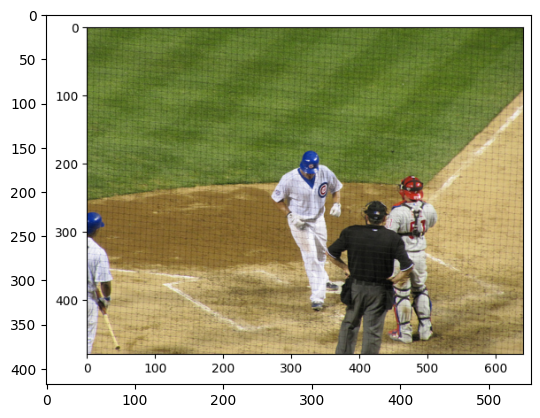

In [38]:
import re # 정규 표현식(Regular Expression)을 사용하기 위한 모듈

# 캡션을 생성할 샘플 이미지 파일 경로
image_file_path = './sample.png'

# Device configuration
# 추론(inference) 시에도 학습 때와 동일한 장치 설정을 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
def load_image(image_file_path, transform=None):
    """하나의 이미지 파일을 불러와서 모델 입력 형식에 맞게 변환하는 함수."""
    # 이미지 파일을 열고 RGB 형식으로 변환
    img = Image.open(image_file_path).convert('RGB')
    # 이미지 크기를 224x224로 조절 (모델 입력 크기)
    img = img.resize([224, 224], Image.Resampling.BILINEAR)
    
    # transform이 지정된 경우, 이미지에 적용
    if transform is not None:
        # unsqueeze(0)를 통해 배치 차원(batch size = 1)을 추가
        img = transform(img).unsqueeze(0)
    
    return img
 
# Image preprocessing
# 추론 시에는 RandomCrop, RandomFlip과 같은 데이터 증강 기법을 사용하지 않음
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
# 학습 시 사용했던 단어 사전을 그대로 불러옴
with open(r'C:/python/ch08/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
# 인코더와 디코더 모델을 생성
# .eval() 모드로 설정. 이는 배치 정규화(BatchNorm)나 드롭아웃(Dropout) 같은 레이어들이
# 학습 때와 다르게 동작하도록 설정함 (예: BatchNorm은 이동 평균/분산을 사용)
encoder_model = CNNModel(256).eval()
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
# 모델을 지정된 장치로 이동
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
# 저장해 둔 학습된 모델의 가중치(파라미터)를 불러옴
encoder_model.load_state_dict(torch.load(r'./models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load(r'./models_dir/decoder-2-3000.ckpt'))


# Prepare an image
# 위에서 정의한 load_image 함수로 이미지를 불러오고 텐서로 변환
img = load_image(image_file_path, transform)
# 이미지 텐서를 지정된 장치로 이동
img_tensor = img.to(device)


# Generate a caption from the image
# 인코더에 이미지를 입력하여 특성 벡터를 추출
feat = encoder_model(img_tensor)
# 디코더의 sample 함수를 호출하여 이미지 특성으로부터 캡션(단어 인덱스 시퀀스) 생성
sampled_indices = decoder_model.sample(feat)
# 생성된 인덱스 텐서를 CPU로 옮기고 numpy 배열로 변환.
# (1, max_seq_length) -> (max_seq_length) 형태로 차원 축소
sampled_indices = sampled_indices[0].cpu().numpy()


# Convert word_ids to words
# 예측된 단어 인덱스들을 실제 단어로 변환
predicted_caption = []
# 생성된 인덱스 시퀀스를 하나씩 순회
for token_index in sampled_indices:
    # 인덱스를 단어로 변환 (i2w 딕셔너리 사용)
    word = vocabulary.i2w[token_index]
    # 변환된 단어를 리스트에 추가
    predicted_caption.append(word)
    # 만약 <end> 토큰이 생성되면 문장이 끝난 것이므로 중단
    if word == '<end>':
        break
# 단어 리스트를 공백으로 연결하여 하나의 문장으로 만듦
predicted_sentence = ' '.join(predicted_caption)
# 정규 표현식을 사용하여 <start>와 <end> 토큰 사이의 실제 캡션 내용만 추출
matched = re.search(r"<start>\s*(.*?)\s*<end>", predicted_sentence)
# 매칭된 그룹 중 첫 번째 그룹(괄호 안의 내용)을 가져옴
sentence = matched.group(1)

# Print out the image and the generated caption
# 생성된 캡션 문장 출력
%matplotlib inline
print (sentence)
# 원본 이미지 파일을 열기
img = Image.open(image_file_path)
# matplotlib을 사용하여 이미지 출력
plt.imshow(img)

plt.show()


In [39]:
import re
# 정규 표현식 예제
predicted_sentence = "<start> a baseball player swings at a ball while the catcher is ready to catch the ball . <end>"
# r"<start>\s*(.*?)\s*<end>"의 의미:
# <start> : 문자열 "<start>"
# \s* : 0개 이상의 공백 문자
# (.*?) : 임의의 문자(.)가 0번 이상(*) 반복되는 것을 찾되, 최소한으로 매칭(?) (non-greedy). 이 부분이 우리가 추출하려는 내용.
# \s* : 0개 이상의 공백 문자
# <end> : 문자열 "<end>"
matched = re.search(r"<start>\s*(.*?)\s*<end>", predicted_sentence)

# group(0)은 전체 매칭된 문자열, group(1)은 첫 번째 괄호에 매칭된 부분을 반환
matched.group(1)

'a baseball player swings at a ball while the catcher is ready to catch the ball .'